# Introduction to Image classification with CNN and CIFAR 10 dataset

This exercise introduces Convolutional Neural Networks for image classification.  In contrast to the Remote Sensing field, image classification in Computer Vision aims at generating one label for the entire image i.e. to classify an entire image into different categories. We use a neural network architecture that uses convolutional layers to extract features using learned weights in filters.

The final output of the model is a series of probabilities (activation scores) with dimension matching the number of classes/labels. For each image, the highest probability is taken as the label/class.

## Dataset

CIFAR 10 is an image dataset commonly used as a reference/baseline dataset in Machine Learning. It is produced by the Canadian Center for Advanced Research. It consists of set of 60,000 images of 10 classes of color images of size 32x32x3. The classes are common objects or animals. For instance, class 4 corresponds cats while class 2 corresponds to automobiles. The images are coarsened colors with Red, Blue, Green chanels. Of the 60,000 images, 50,000 are reserved for training while 10,000 are reserved for testing.

## Interesting Links
- lenet architecture: http://yann.lecun.com/exdb/lenet/

- lenet5: https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342

- cross entropy loss: https://gombru.github.io/2018/05/23/cross_entropy_loss/




# Documentation and packages

First, we set up the code by providing information on the Authors, Creation dates, version by importing relevant python packages. Documenting and providing context and information within a script is important as it is often the case that code will be reused for other applications or other users/colleagues Good documentation improves code reproducibility as well.



In [35]:

import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Deep learning packages
import  tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Activation, MaxPool2D,MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
#from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization

import subprocess
import pandas as pd
import os, glob
import numpy as np
from tensorflow.keras.utils import to_categorical


np.set_printoptions(suppress=True) #suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.4f' % x) #dispaly with four decimal


In [2]:
#Used in defining functions
from typing import List, Tuple, Dict, Any
from pandas.core.arrays import boolean

Check which tensorflow version is installed in Colab

In [3]:
tensorfow_version = tf.__version__
print(tensorfow_version)

2.15.0


The list of packages above constains some of the most common packages used in data science, deep learning.  In this exercise, we use matplotlib and seaborn to make graphs, plots and visualize images. Keras is used in creating the deep learning model. Sklearn provides many functionalities and methods (SVM, random forest etc.) for Machine Learning.

In [4]:
def create_dir_and_check_existence(path: str)->str:
    '''
    Create output directory

    :param path: path to output directory
    :return: message string
    '''
    try:
        os.makedirs(path)
        message_string = "directory created"
    except:
        message_string = "directory already exists"
    return message_string

from typing import Callable, Any, Iterable, List, Tuple


def generate_accuracy(model: Any,
                      y_test: np.array,
                      x_test: np.array,
                      class_names: str =None)->pd.DataFrame:

  """
  Function to predict and generate accuracy metrics (precision and recall) for each model given input x and y test.

  :param model: keras model
  :param y_test: Input target for test
  :param y_train: target train labels used in classification
  :param class_names: labels for the class predicted

  :return report_df: pandas data frame with accuracy metrics

  """

  # we can store the array in a data.frame and get the max
  y_score = model.predict(x_test)
  y_score.shape
  y_pred_test_df = pd.DataFrame(y_score)
  y_pred_test_df['y_pred_test'] = y_pred_test_df.idxmax(axis = 1) #one to go across the column for each row
  y_pred_test_df


  y_pred_test = y_pred_test_df['y_pred_test']
  report_dict=classification_report(y_test,
                                      y_pred_test,
                                      target_names=class_names,
                                      output_dict=True)
  report_df = pd.DataFrame(report_dict)
  #confusion_matrix_val = confusion_matrix(y_test,y_pred_test)  #not in use here
  model_name = model._name
  #display(report_df)
  report_df = (report_df.drop(columns=['macro avg','weighted avg'])
                        .drop(labels=['f1-score','support'])
                        .assign(model_name= lambda x: model_name)
                        .assign(num_param= lambda x: model.count_params())
                        .reset_index()
                        .rename(columns={'index':'metric'})
              )

  return report_df


In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).

In [6]:
############################################################################
#####  Parameters and argument set up ###########

#ARG 1
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_to_CNN/data/'
#ARG 2
out_dir = "/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_to_CNN"

#ARGS 3:
create_out_dir = True #create a new ouput dir if TRUE
#ARG 4
out_suffix = "intro_to_cnn_20240310" #output suffix for the files and ouptut folder
#ARG 5
NA_value = -9999 # currently not used: Nan value
#ARG 6
random_seed=42 #not yet used

## Input data
#ARG 7-8
run_model = False #Retrain model if True
model_path = '/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_to_CNN/models/output_data_intro_to_cnn_02232022'

In [7]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier


In [8]:
print(out_dir)

/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_to_CNN/outputs/output_data_intro_to_cnn_20240310


# Workflow/pipeline

In this exercise, we will perform the analysis using a workflow that may be succintly described using the following steps:
1. **Visualization and exploration of data**
- Obtain data from Keras
-Visualize feature images and target value.
- Explore if data is balanced
2. **Data processing**
- change image data type
- rescale image values
- change label to one hot encoding
3. **Exploring Convolutional layers**
- instantiate a conv2d layers in keras tensorflow
- passing an image through a conv2d layer
- understanding image output size, padding and stride
4. **Build and train model**
- build keras models
- fit and train models
5. **Accuracy Assessment**
- use test data to generate an accuracy assessment
- assess accuracy using precision and recall.
6. **Conclusions**



# 1. Visualization and exploration of the Dataset

We will first load the dataset using the keras.dataset API. Keras provides the CIFAR dataset already split into training and testing data. The input feature data is an RGB image of 10 differenct classes while the target is the label of the image.
The data loaded is in numpy format and we can check the size of the training and testing data below:

In [9]:
#example of loading the cifar10 dataset
#from keras.datasets import cifar10
# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Size of the input feature CIFAR training dataset: ",x_train.shape)
print("Size of the input feature CIFAR testing dataset: ",x_test.shape)
print("Size of the input target CIFAR training dataset: ",y_train.shape)
print("Size of the input target CIFAR testing dataset: ",y_test.shape)

170498071/170498071 [==============================] - 5s 0us/step
Size of the input feature CIFAR training dataset:  (50000, 32, 32, 3)
Size of the input feature CIFAR testing dataset:  (10000, 32, 32, 3)
Size of the input target CIFAR training dataset:  (50000, 1)
Size of the input target CIFAR testing dataset:  (10000, 1)


<class 'numpy.ndarray'>
(32, 32, 3)


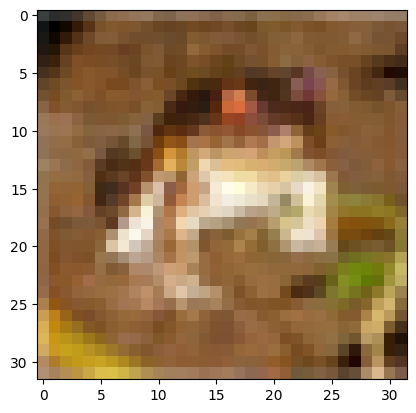

In [10]:
print(type(x_train)) #check that the data type is numpy array
print(x_train[0].shape) #selecting sample 0
plt.imshow(x_train[0])

In [11]:
print(y_train[0].shape)
y_train[0]

(1,)


array([6], dtype=uint8)

In [12]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

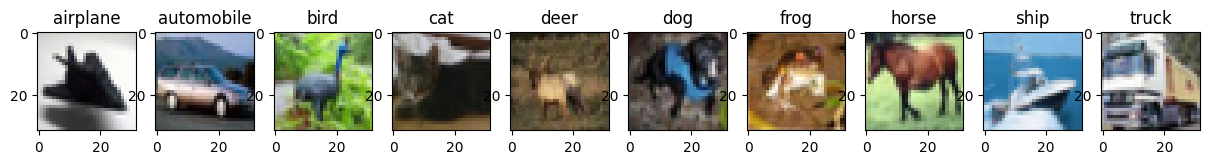

In [13]:
# Let's explore the first 10 images with labels
# Print figure with 10 random images from each
num_classes=10
#fig = plt.figure(figsize=(8,3))
f, ax = plt.subplots(1,num_classes,figsize=(15,15))

for class_val in range(num_classes):

    class_index = np.where(y_train[:]==class_val)[0] #returns tuple because it is a two dimensional array
    #take first element matching the class as it is relevant to the class
    image = x_train[class_index]
    #print("Image size",image.shape)
    ax[class_val].imshow(image[0])
    ax[class_val].set_title(class_names[class_val])


In [14]:
#check if dataset is balanced.
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   0    1    2    3    4    5    6    7    8    9]
 [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]]


# 2. Data Processing

The input data comes as byte for each of the channels. This means that it is within the 0 to 255 range. Neural Networks and deep learning model converge faster when values are within the 0-1 range . We will process the data to prepare the inputs for the model in 3 steps:

- change data type for images
- change scale to 0-1
- change label to one hot encoding

In [15]:
print(x_train.dtype)
print(y_train.dtype)

uint8
uint8


First we need to convert the data type from integer to float.


In [16]:
# change data type to float
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# scale between 0 and 1
x_train = x_train/255
x_test = x_test/255

#Change label to one hot encoding using from keras.utils.to_categorical

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [17]:
y_train_cat[0] #this is now one hot encoded

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [18]:
x_train.shape[1:] #first image

(32, 32, 3)

#3. Exploring Convolutional Layers

In this exercise, we build a CNN (Convolutional Neural Network) model. This requires using conv2d layers on images. We first explore conv2d layers to better understand how they work. We do the following:

- instantiate a conv2d layers in keras tensorflow
- passing an image through a conv2d layer
- understanding image output size, padding and stride

useful links:

- https://keras.io/api/layers/convolution_layers/convolution2d/
- https://kvirajdatt.medium.com/calculating-output-dimensions-in-a-cnn-for-convolution-and-pooling-layers-with-keras-682960c73870
- https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d
- https://towardsdatascience.com/understanding-2d-dilated-convolution-operation-with-examples-in-numpy-and-tensorflow-with-d376b3972b25
-https://www.wolframalpha.com/input?i=floor%5B%28W%2B2*p+-+1*%28k-1%29+-+1%29%2FS%2B1%5D+for+W%3D256%2C+p%3D1%2C+k%3D%7B2%2C3%2C4%7D%2C+S%3D2

Let's instantiate a conv2d layer. Note that we have many parameters availabe:

- filter: number of kernels to run to create output features maps
- kernel_size: kernel size used defined in heightxwidth, typically (3,3)
- stride: the size of the steps when moving the kernel across images in height and width. If (1,1) no pixels are skipped.
- padding: if valid there is no padding, if same padding is used to keep the same input size in the output image.
- dilation_rate: create a kernel with dilation (wider receptive field with gaps)
- activation: activation function to apply to feature output map

In [19]:
conv2D_layer = layers.Conv2D(
    filters=8,
    kernel_size=(3,3),
    strides=(1, 1),
    padding="valid",
    data_format=None,
    dilation_rate=(1, 1),
    activation=None)
conv2D_layer

Let's now select an image to pass throught the layer. Note that we havee an input image of:
- height (row):32
- width (col): 32
- channel: 3

In [21]:
image_example = x_train[0,:,:,:]
print(type(image_example))
image_example.shape

<class 'numpy.ndarray'>


(32, 32, 3)

We need a 4 dimensional tensor to pass the image through the conv2d layer, so we add a dimension 1 with axis 0. This represent the sample dimension. In this case, we only hae one sample.

In [22]:
image_example = np.expand_dims(image_example, axis=0)
image_example.shape

(1, 32, 32, 3)

The output of the conv2d layer is a 4 dimensional tensor with 8 channels corresponding to the new feature generated.

In [23]:
image_output = conv2D_layer(image_example)
image_output.shape

TensorShape([1, 30, 30, 8])

Notice that we lost 2 pixels on height (row) and width (column) because we set the padding to valid so that there is no padding. The general formula for number of pixels loss based on the size of the filter is:

- i = image size (assuming square image)
- k = filter size (assuming square filter)
- p = padding
- s = stride

**Case 1**: no padding and stride 1

- output size = i - k + 1 = 32 - 3 + 1 = 30
- output size = i - k + 1 = 32 - 5 + 1 = 28

**Case 2**: padding and stride

output size = ((i - k + 2 * p) /s ) + 1



In [24]:
conv2D_layer = layers.Conv2D(
    filters=8,
    kernel_size=(5,5),
    strides=(2, 2),
    padding="valid",
    data_format=None,
    dilation_rate=(1, 1),
    activation=None)
image_output = conv2D_layer(image_example)
image_output.shape

TensorShape([1, 14, 14, 8])

# 4. Building and training Models

We will be using the sequential api to build the CNN model to classify the 10 CIFAR classes.
We will compare 3 model architectures:

1. model_dnn: A DNN model using a flatten layer without any CNN layer.
2. model_lenet5: The Lenet 5 model, a famous CNN model introduced by Yann Lecun.
3. model_cnn: A more complex and recent and CNN architecture using the relu function and some drop out layers.

## 4.1 Build a Dense Neural Network for CIFAR

First, we will use a fully connected network also called dense network because every node in successive layers are connected to the next and previous layers.
This can result in a large number of parameters even with a very simple architecture.

In [25]:
print(x_train.shape)
INPUT_SHAPE = x_train.shape[1:]
print(INPUT_SHAPE)

(50000, 32, 32, 3)
(32, 32, 3)


In [26]:
model_dnn = keras.Sequential()
model_dnn.add(layers.InputLayer(input_shape=INPUT_SHAPE))#layer can be dropped if use 'input_shape' param in next layer
model_dnn.add(layers.Flatten())
model_dnn.add(layers.Dense(512,activation='relu'))
model_dnn.add(layers.Dense(10,activation='softmax'))

model_dnn.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model_dnn._name = 'model_dnn' #set keras model name

In [27]:
32*32*3

3072

In [28]:
model_dnn.summary()

Model: "model_dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1578506 (6.02 MB)
Trainable params: 1578506 (6.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# Fit model
batch_size =128
epochs = 2
history_model_dnn = model_dnn.fit(x_train,
                                  y_train_cat,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  validation_split = 0.2,
                                  shuffle=True)


Epoch 1/2
313/313 [==============================] - 13s 38ms/step - loss: 1.9962 - accuracy: 0.3042 - val_loss: 1.8276 - val_accuracy: 0.3516
Epoch 2/2
313/313 [==============================] - 12s 39ms/step - loss: 1.7571 - accuracy: 0.3788 - val_loss: 1.7622 - val_accuracy: 0.3745


## Building the Lenet CNN model

Lenet5 is named after Yann Lecun, one of the 'father' of Deep Learning. It is one of the first model with a Convolutional Neural Network architecture.
LeNet-5 contains 5 layers including 2 convolutional hidden layers (followed by averaged pooling) and 2 fully connected hidden layer.

![lenet.png](https://raw.githubusercontent.com/MostafaGazar/mobile-ml/master/files/lenet.png)
LeNet-5 Architecture. Credit: [LeCun et al., 1998](http://yann.lecun.com/exdb/publis/psgz/lecun-98.ps.gz)

In [ ]:
INPUT_SHAPE = x_train.shape[1:]
print(INPUT_SHAPE)
#height X width X pixel

(32, 32, 3)


In [30]:
model_lenet5 = keras.Sequential()

#Conv block 1
model_lenet5.add(layers.InputLayer(input_shape=INPUT_SHAPE))#layer can be dropped if use 'input_shape' param in next layer

model_lenet5.add(layers.Conv2D(filters=6, kernel_size=(5,5), strides=(1, 1),
    padding="valid",activation='tanh'))
#model_lenet5.add(layers.Conv2D(filters=6, kernel_size=(5,5), strides=(1, 1),
#    padding="valid",activation='tanh', input_shape=INPUT_SHAPE))

model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2), strides=None))#max pooling more in use currently
#Conv block 2
model_lenet5.add(layers.Conv2D(filters=16, kernel_size=(5,5),
                               strides=(1, 1),padding="valid", activation='tanh'))
model_lenet5.add(layers.AveragePooling2D())
#DNN/Fully Connected Network
model_lenet5.add(layers.Flatten())
model_lenet5.add(layers.Dense(units=120, activation='relu'))
model_lenet5.add(layers.Dense(units=84, activation='relu'))
#Output
model_lenet5.add(layers.Dense(units=10, activation = 'softmax'))

# Compile model and set loss and optimizer

model_lenet5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_lenet5._name = 'model_lenet5' # set keras model name

In [31]:
model_lenet5.summary()

Model: "model_lenet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 120)              

In [32]:
# Fit model
batch_size =128
epochs = 2
history_model_lenet5 = model_lenet5.fit(x_train,
                y_train_cat,
                batch_size=batch_size,
                epochs=epochs,
                validation_split = 0.2,
                shuffle=True)

Epoch 1/2
313/313 [==============================] - 24s 75ms/step - loss: 1.8448 - accuracy: 0.3293 - val_loss: 1.6735 - val_accuracy: 0.3967
Epoch 2/2
313/313 [==============================] - 24s 76ms/step - loss: 1.5592 - accuracy: 0.4458 - val_loss: 1.5344 - val_accuracy: 0.4460


## Building a more complex CNN model

In [33]:
#parameters:
print(INPUT_SHAPE)
num_classes =10


(32, 32, 3)


In [37]:
model_cnn = Sequential()

## CNN part
#Block 1
model_cnn.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                 activation='relu', input_shape=INPUT_SHAPE))
model_cnn.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))


#Block 2
model_cnn.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model_cnn.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))

#Block 3:
model_cnn.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model_cnn.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2))) #becomes 4x4 image

## DNN part
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1024,activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(num_classes, activation='softmax'))

# Compile model

model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_cnn._name = 'model_cnn' # set keras model name
model_cnn.summary()

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                    

In [38]:
# Fit model
batch_size =128
epochs = 2
# Fit model: about 10-12 minutes for 2 epochs

cnn_history = model_cnn.fit(x_train,
                y_train_cat,
                batch_size=batch_size,
                epochs=epochs,
                validation_split = 0.2,
                shuffle=True)

Epoch 1/2
313/313 [==============================] - 285s 906ms/step - loss: 1.6242 - accuracy: 0.4022 - val_loss: 1.2849 - val_accuracy: 0.5283
Epoch 2/2
313/313 [==============================] - 286s 915ms/step - loss: 1.1500 - accuracy: 0.5864 - val_loss: 0.9872 - val_accuracy: 0.6495


# Compiling and fitting models

In [39]:
## Loop through this
list_models=[model_dnn,model_lenet5,model_cnn] #use the model

list_hist_df=[]
epochs = 10
batch_size = 128

if run_model==True:

  for model in list_models:
  #if run_model=True then train model and store weights and history

    # Fit model: takes between 50 and 60 minutes

    model_name = model._name
    history_model = model.fit(x_train,
                y_train_cat,
                batch_size=batch_size,
                epochs=epochs,
                validation_split = 0.2,
                shuffle=True)

    hist_df = pd.DataFrame(history_model.history)

    # save to json:
    hist_json_file = 'history_'+model_name+'_'+out_suffix+'.json'
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)
    # save to csv:
    hist_csv_file = 'history_'+model_name+'_'+out_suffix+'.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    # serialize weights to HDF5
    model.save_weights(model_name+'_'+out_suffix+'.h5')
    list_hist_df.append(hist_df)
    print("Saved model to disk ", model_name)

  #if run_model=False then load models weights and loss history from h5 file
if run_model==False:
  if model_path is None:
    model_path = os.path.join(out_dir,fileglob) #classified
    print('Set model path to output directory')

  model_names=['model_dnn','model_lenet5','model_cnn']
  i=0
  for model_name in model_names:
    print(i)
    print(model_name)
    fileglob ="*"+model_name+"*.h5"
    model_path_filename= os.path.join(model_path,fileglob) #classified
    model_path_filename = glob.glob(model_path_filename,recursive=False)[0]
    model=list_models[i]
    model.summary()
    print('This is the model path ',model_path_filename)
    model.load_weights(model_path_filename)
    fileglob ='*'+model_name+"*.csv"
    history_model_path = os.path.join(model_path,fileglob) #classified
    history_model_path = glob.glob(history_model_path,recursive=False)[0]
    hist_df = pd.read_csv(history_model_path)
    list_models[i]=model #put the updated model with weights in the list
    list_hist_df.append(hist_df)
    i=i+1

0
model_dnn
Model: "model_dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1578506 (6.02 MB)
Trainable params: 1578506 (6.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
This is the model path  /content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_to_CNN/models/output_data_intro_to_cnn_02232022/model_dnn_intro_to_cnn_02232022.h5
1
model_lenet5
Model: "model_lenet5"
_________________________

In [40]:
list_models

In [41]:
print(model._name)

model_cnn


Now let's take a look at the loss and accuracy for the training of the three models. For each epoch, keras computes a loss and accuracy metrics. We extracted these informations for the callback keras object in the previous step during the fitting process.

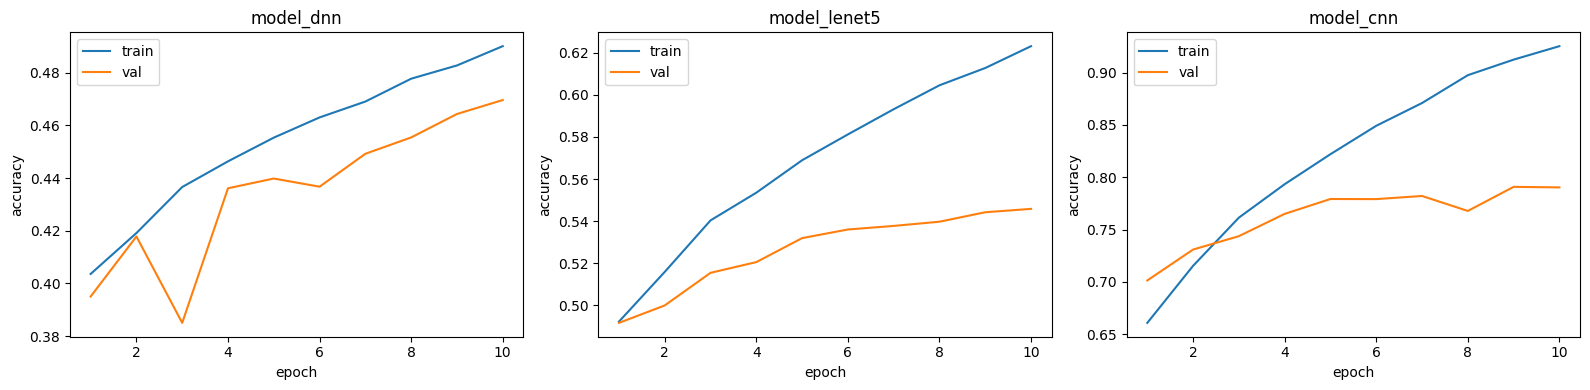

In [42]:
num_models=3
fig, ax = plt.subplots(1,num_models,figsize=(16,4))
model_names=['model_dnn','model_lenet5','model_cnn']

for model_val in range(num_models):
  hist_df=list_hist_df[model_val]
  hist_df['epoch']=np.arange(1,epochs+1)
  ax[model_val].plot(hist_df['epoch'],hist_df['accuracy'],label='train')
  ax[model_val].plot(hist_df['epoch'],hist_df['val_accuracy'],label='val')
  ax[model_val].set_title(model_names[model_val])
  ax[model_val].set_xlabel('epoch')
  ax[model_val].set_ylabel('accuracy')
  ax[model_val].legend()

fig.tight_layout()
plt.savefig(f'CNN_model_learning_curves_comparison_accuracy_{out_suffix}.png')

We repeat the same steps for loss. Note that this could be turned into a function to avoid copying similar code.

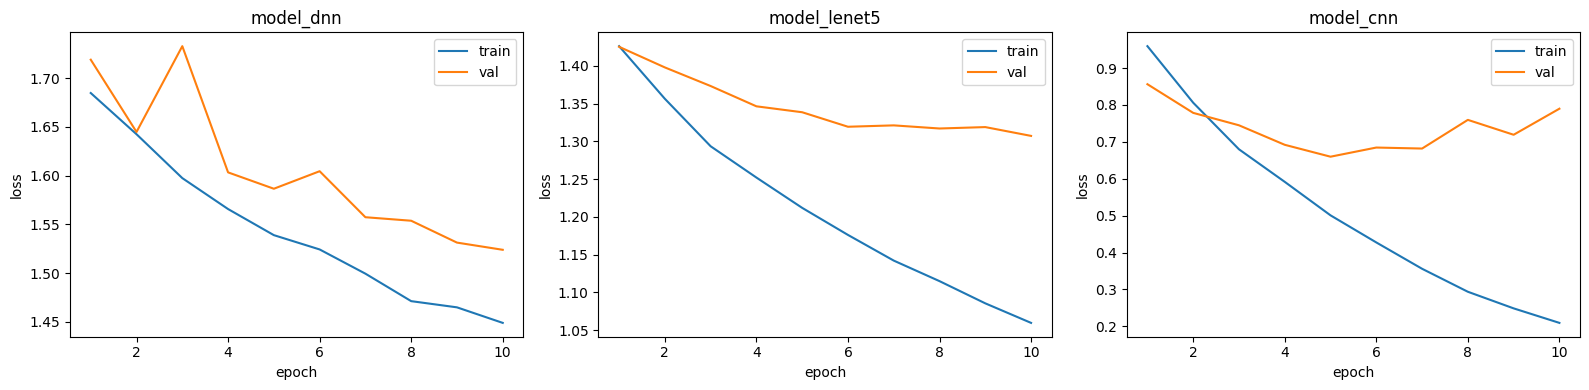

In [43]:
num_models=3
fig, ax = plt.subplots(1,num_models,figsize=(16,4))
model_names=['model_dnn','model_lenet5','model_cnn']

for model_val in range(num_models):
  hist_df=list_hist_df[model_val]
  hist_df['epoch']=np.arange(1,epochs+1)

  ax[model_val].plot(hist_df['epoch'],hist_df['loss'],label='train')
  ax[model_val].plot(hist_df['epoch'],hist_df['val_loss'],label='val')
  ax[model_val].set_title(model_names[model_val])
  ax[model_val].set_xlabel('epoch')
  ax[model_val].set_ylabel('loss')
  ax[model_val].legend()

fig.tight_layout()

plt.savefig(f'CNN_model_learning_curves_comparison_loss_{out_suffix}.png')

# 5. Accurary Assessment and models comparison

We assess models using the test data. The steps as follow:

1. generate test samples and predict using each model
2. compute accuracy metrics
3. compare models using metrics and complexity.

In #1, we generate predictions using the test samples or the model_dnn, model_lenet and model_cnn.

In #2, we use the soft and hard predictions to generate confusion metrics and accuracy metrics such as AUC and precision, recall.

In #3, we compare the three models using the metrics as well as number of parameters (as proxy for model complexity).

1/1 [==============================] - 0s 38ms/step
[[0.03416098 0.00057902 0.00000189 0.00011004 0.00000022 0.00000008
  0.00000046 0.00000808 0.9635308  0.00160842]]
ship
8
(1, 32, 32, 3)


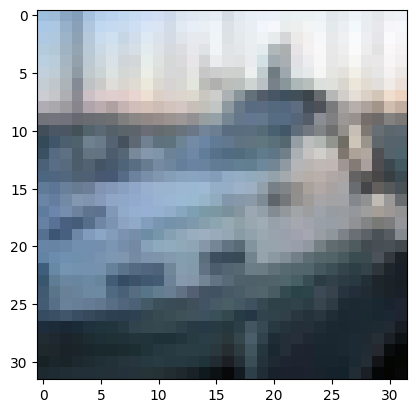

In [45]:
test_image = x_test[2:3] #select third image test sample
y_score = model_cnn.predict(test_image)
print(y_score)
print(class_names[np.argmax(y_score)])
y_pred_test= np.argmax(y_score)
print(y_pred_test)
print(test_image.shape)
plt.imshow(test_image[0])

In [46]:
#y_test is a OHE vector but x_test is an image!!
#y_test_cat = to_categorical(y_test, num_classes=10)
y_test_cat.shape

(10000, 10)

In [47]:
# we can store the array in a data.frame and get the max
#This steps is called 'inference' in deep learning.
y_score = model_cnn.predict(x_test)
print(type(y_score))
y_score.shape

313/313 [==============================] - 22s 70ms/step
<class 'numpy.ndarray'>


(10000, 10)

In [48]:
y_pred_test_df = pd.DataFrame(y_score)
y_pred_test_df['y_pred_test'] = y_pred_test_df.idxmax(axis = 1) #one to go across the column for each row

y_pred_test_df

,0,1,2,3,4,5,6,7,8,9,y_pred_test
0,0.0000,0.0000,0.0000,0.9644,0.0000,0.0336,0.0019,0.0000,0.0000,0.0000,3
1,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9998,0.0000,8
2,0.0342,0.0006,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.9635,0.0016,8
3,0.9887,0.0040,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0073,0.0000,0
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,6
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0688,0.0000,0.0181,0.6905,0.0001,0.0964,0.0000,0.0000,0.1261,0.0000,3
9996,0.0000,0.0000,0.0000,0.9440,0.0005,0.0111,0.0444,0.0000,0.0000,0.0000,3
9997,0.0000,0.0000,0.0001,0.0000,0.0000,0.9999,0.0000,0.0000,0.0000,0.0000,5
9998,0.0011,0.9982,0.0007,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1


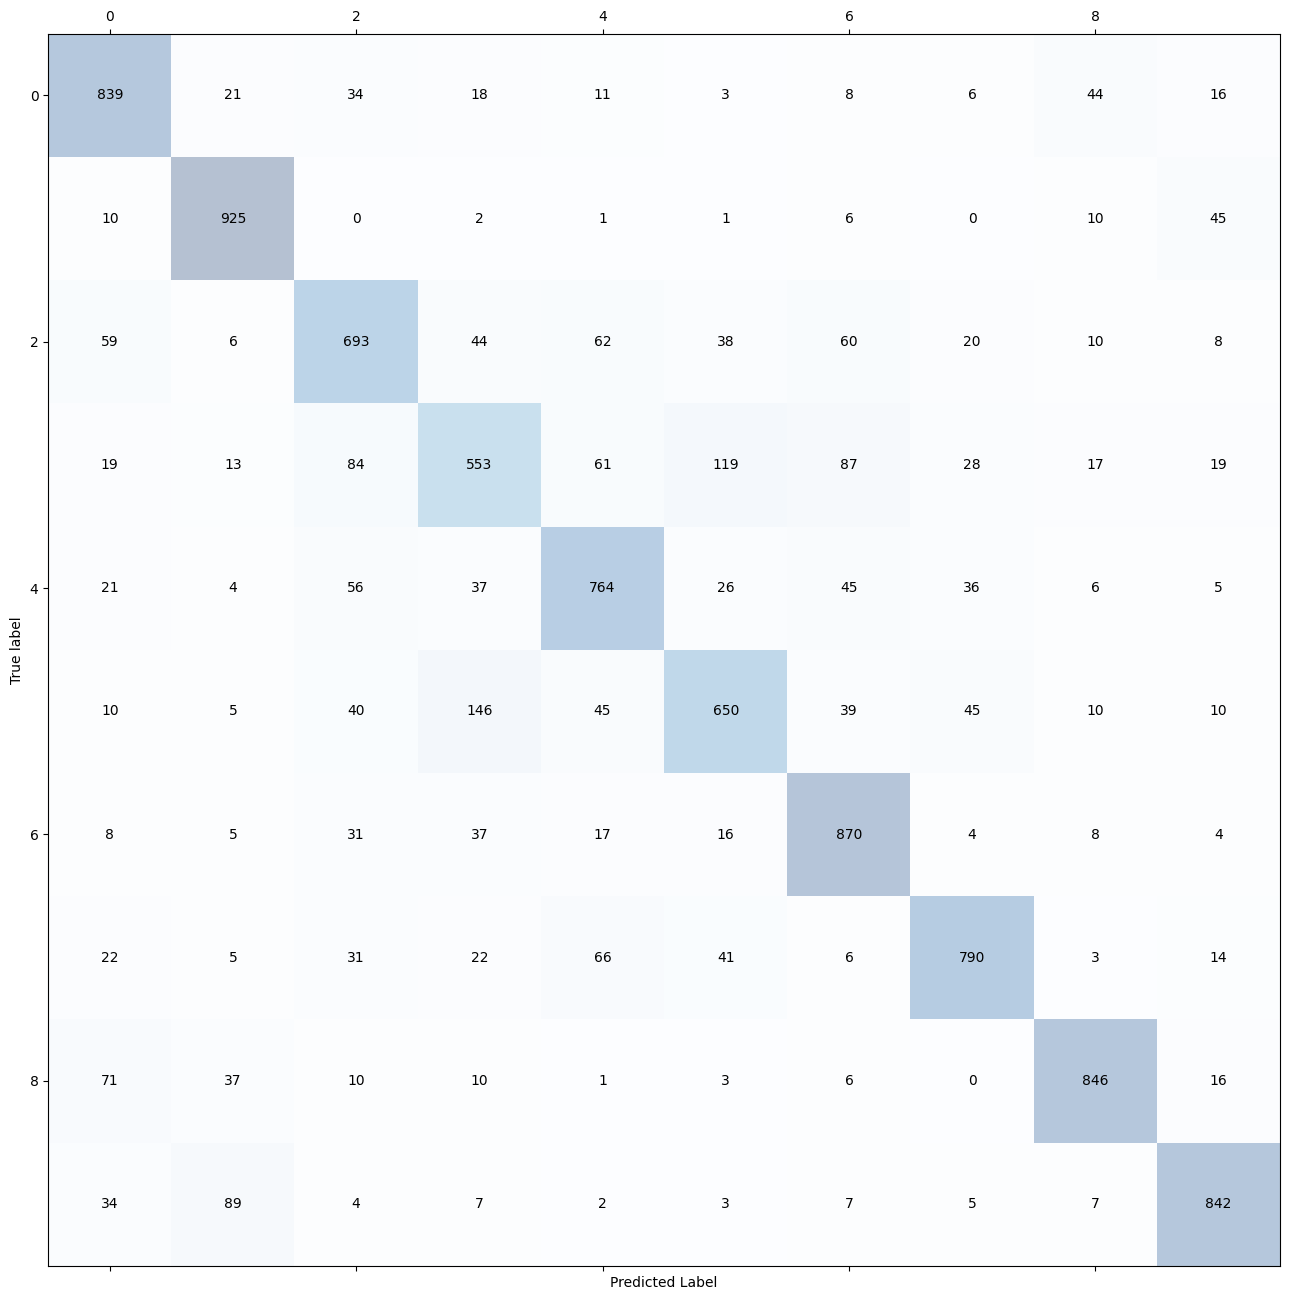

In [49]:
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
y_pred_test = y_pred_test_df['y_pred_test']
report_dict=classification_report(y_test,
                                      y_pred_test,
                                      output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
confusion_matrix_val = confusion_matrix(y_test,y_pred_test)

fig, ax = plt.subplots(figsize=(16,16))
ax.matshow(confusion_matrix_val,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confusion_matrix_val.shape[0]):
  for j in range(confusion_matrix_val.shape[1]):
    ax.text(x=j,y=i,
               s=confusion_matrix_val[i,j],
               va='center',
               ha='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('True label')

In [50]:
report_df
# Note we have 1000 test samples per class
#precision: number of correctly predicted categories out of predictions (True Positive/(True Positive + False Positve))
#recall: (True Positive/(True Positive + False Negative))


,precision,recall,f1-score,support
0,0.7676,0.8390,0.8017,1000.0000
1,0.8333,0.9250,0.8768,1000.0000
2,0.7050,0.6930,0.6989,1000.0000
3,0.6313,0.5530,0.5896,1000.0000
4,0.7417,0.7640,0.7527,1000.0000
5,0.7222,0.6500,0.6842,1000.0000
6,0.7672,0.8700,0.8154,1000.0000
7,0.8458,0.7900,0.8170,1000.0000
8,0.8803,0.8460,0.8628,1000.0000
9,0.8601,0.8420,0.8509,1000.0000


Let's use a function to generate the accuracy metrics for all models.



In [51]:
list_report_df = []
for model in list_models:
  report_df = generate_accuracy(model,y_test,x_test,class_names=class_names )
  list_report_df.append(report_df)
#list_report_df

from functools import reduce
report_df = reduce(lambda df1,df2: df1.merge(df2,"outer"),list_report_df)
report_df

313/313 [==============================] - 18s 58ms/step


,metric,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck,accuracy,model_name,num_param
0,precision,0.5770,0.4982,0.3840,0.3917,0.3863,0.4395,0.4897,0.4847,0.6117,0.4973,0.4808,model_dnn,1578506
1,recall,0.5020,0.7000,0.2780,0.2640,0.4470,0.2980,0.5680,0.6020,0.5860,0.5630,0.4808,model_dnn,1578506
2,precision,0.5412,0.7044,0.4403,0.3772,0.4691,0.4935,0.6255,0.6317,0.6250,0.5598,0.5435,model_lenet5,62006
3,recall,0.6760,0.5480,0.4390,0.3930,0.4560,0.4170,0.5880,0.6260,0.6550,0.6370,0.5435,model_lenet5,62006
4,precision,0.7676,0.8333,0.7050,0.6313,0.7417,0.7222,0.7672,0.8458,0.8803,0.8601,0.7772,model_cnn,2395434
5,recall,0.8390,0.9250,0.6930,0.5530,0.7640,0.6500,0.8700,0.7900,0.8460,0.8420,0.7772,model_cnn,2395434


A few observations that come out of the assessement:
1. accuracy show that the best model is model_cnn. It makes sense since it is the most complex architecture (num_param).
2. There are large variation in the precision and recall among classes.
3.The class with the highest recall is automobile with 0.925 using model cnn. The precision is lower though with 0.84.



### Understanding the number of parameters

In this exercise, we produced 3 different architectures with an increasing degree of complexity: DNN,Lenet and Deeper CNN.

DNN is a fully connected neural network (also called dense) because every node in the hidden layers is connected to the previous and next layer. This generates a lof of parameters. If we look at the accuracy table, we can see that we have 1.578 millons parameters even though we only have one hidden layer.Contrast this to Lenet, a five layer network with 4 hidden layers but that only contains 62,006 parameters. The most complex model 'model_cnn' contains 2,395,434 parameters and has 7 hidden layers (max pooling layers have no trained parameters).

In general, going from DNN to CNN, you should see a drop in number of parameters. Let us quickly do a count of parameters for the first and last models used as an example:

**Model_dnn**

In the first architecture we had:

- input layer: 32x32x3 = 3072
- dense 1: 512 nodes
- output: 10 nodes

dense 1: HxWxC x nodes in dense 1 + biases
dense 1: 32x32x3x512+512= 1,573,376

Compare the numbers to the number of parameters in a CNN layer below.

**Model_cnn**

In the third architecture we had:



- conv2d_2: 32x32x32
```
The general structure to count parameters is as follow:
3 input chanels, 32 filters, 3x3 kernels, 32 bias values
channel_in x channel_out x kernel+bias
3x32x3x3+32= 896
```
- conv2d_3: 32x32x32
32x32x3x3+32= 9248

- conv2d_4: 16x16x64
32x64x3x3+64= 18496

- conv2d_5: 16x16x64
64x64x3x3+64= 36928

- conv2d_6: 8x8x128
64x128x3x3+128= 73856

- conv2d_7: 8x8x128
128x128x3x3+128= 147,584

- dense1: 1024
2048x1024+1024= 2,098,176

- dense 6: 10
1024x10+10= 10250

In [52]:
model_cnn.summary()

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                    

In [ ]:
model_dnn.summary()

Model: "model_dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1578506 (6.02 MB)
Trainable params: 1578506 (6.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#6. Conclusions

In this exercise, we introduced CNN layers for image classification. We used the CIFAR 10 data and predicted the category of each image out of 10 labels. We experimented with the Lenet model and another alternative 10 layers CNN model compared to a fully connected (dense) neural network architecture.

As expected we found that the most complex CNN model performed the best. We also found that CNN performs better in general and allows for a substantials reduction of the number of paramaters.

In [ ]:
############################# END OF SCRIPT ###################################